In [11]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


## Visualização de escoamento


### Mapa de calor
0 - azul

1 - vermelho

eixo x,y e z (plano)

### Mapa de resultados numeros com vetores de mesmo tamanho


### Resultados numeros com linhas de corrente
- linhas de corrente: linhas tangentes a velocidade (somatorio). linha de tangete a linha do vetor velocidade (trajetoria da particula do vetor da velocidade)

[ ] Implementação do programa e simulaçoes

[ ] Coleta e analise de dados

- Ajustar os aleatórios do RCE.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive

11ª Reunião (Remota)
- Verificar pendências
- Ajustar o RCE, seguindo passo a passo no chat do google.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive
- Tipo, qtde e limite de variáveis de decisão são dados de entrada e impactam em ajuste da função individual do DEAP (isso será visto depois).
- Verificar se a explicação do resultado e os gráficos estão corretos.

## Classe Setup e DataExploration

In [12]:
class Setup:
    def __init__(self, params):
        self.params = params
        self.CXPB = params["CROSSOVER"]
        self.MUTPB = params["MUTACAO"]
        self.NGEN = params["NUM_GENERATIONS"]
        self.POP_SIZE = params["POP_SIZE"]
        self.IND_SIZE = params["IND_SIZE"]
        self.CROSSOVER, self.MUTACAO, self.NUM_GENERATIONS, self.POPULATION_SIZE = (
            self.CXPB,
            self.MUTPB,
            self.NGEN, 
            self.POP_SIZE,
        )
        self.SIZE_INDIVIDUAL = 10
        self.evaluations = 0
        self.num_repopulation = int(self.NUM_GENERATIONS * 0.20)
        self.type = params["type"].lower()
        if self.type == "maximize":
            print("Método escolhido: Maximizar")
            creator.create("Fitness", base.Fitness, weights=(1.0,))
        else:
            print("Método escolhido: Minimizar")
            creator.create("Fitness", base.Fitness, weights=(-1.0,))

        # creator.create("Individual", list, fitness=creator.Fitness)

        self.dataset = {}
        self.beta_constants = {}


        #!Criando invidivuo
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create(
            "Individual", list, fitness=creator.FitnessMin, rce=str, index=int
        )
        self.toolbox = base.Toolbox()
        # todo gerando atributos ao ind
        self.toolbox.register(
            "attr_rce", random.uniform, 0.0, 9.9
        )  
        self.toolbox.register("attr_int", random.uniform, 1, 1000)

        self.toolbox.register("attribute", random.uniform, -5.12, 5.12)
        self.toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            self.toolbox.attribute,
            n=self.SIZE_INDIVIDUAL,
        )

        #paramentos evolutivos
        self.toolbox.register(
            "population", tools.initRepeat, list, self.toolbox.individual
        )
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate_fitness)

    def evaluate_fitness(self, individual):
        if self.type == "minimaze":
            result = minimize(self.rastrigin, x0=np.zeros(self.IND_SIZE), method="BFGS")
            fitness_value = result.fun
        return fitness_value

    def gerarDataset(self, excel):
        df = pd.read_excel(excel)
        print(df.columns)
        self.dataset = {
            "CXPB": self.CROSSOVER,
            "TAXA_MUTACAO": self.MUTACAO,
            "NUM_GEN": self.NUM_GENERATIONS,
            "POP_SIZE": self.POPULATION_SIZE,
            "IND_SIZE": self.SIZE_INDIVIDUAL,
            "evaluations": self.evaluations,
            "NUM_REPOPULATION": self.num_repopulation,
        }

    def rastrigin(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.SIZE_INDIVIDUAL
        for i in range(self.SIZE_INDIVIDUAL):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rastrigin_decisionVariables(self, individual, decision_variables):
        self.evaluations += 1
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rosenbrock(self, x):
        return np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def globalSolutions(self):
        n_dimensions = 2

        try:
            rastrigin_result = minimize(
                self.rastrigin, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            rosenbrock_result = minimize(
                self.rosenbrock, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)

        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)


class DataExploration:
    def __init__(self):
        self.fit_array = []

    def default_rastrigin(self,x, y):
        return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))


    def generateSimpleDataset(self):
        # Geração dos dados
        data = pd.DataFrame(
            {
                'x': np.linspace(-5, 5, 400),
                'y': np.linspace(-5, 5, 400)
            }

        )

        #display(data)

        # Generate meshgrid data
        x = np.linspace(-5.15, 5.15, 100)
        y = np.linspace(-5.15, 5.15, 100)
        X, Y = np.meshgrid(x, y)

        # Calculate function values
        #print(X.shape,Y.shape)

        return X,Y

    def plot_Rastrigin_2D(self,X, Y, Z_rastrigin,logbook ,best_variables =[] ):
        fig = plt.figure(figsize=(18, 10))
        ax1 = fig.add_subplot(231)
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)
        line1 = ax1.plot(generation, statics["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(generation, statics["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(generation, statics["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        ax1.set_title("GERAÇÃO X FITNESS")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")


        # Rastrigin 2D
        ax2 = fig.add_subplot(232)
        ax2.contourf(X, Y, Z_rastrigin, levels=50, cmap='viridis')
        #ax2.plot(best_variables, color='red',)
        for num in range(len(best_variables)):
            var_x = round(best_variables[num])
            var_y = best_variables[num]
            ax2.scatter(var_x,var_y, color = "pink",    marker="o" , label='best variables')
        ax2.set_title('Rastrigin Function 2D')
        ax2.set_xlabel("X")
        ax2.set_ylabel('Y')


        #Rastrigin 3D
        ax5 = fig.add_subplot(233, projection='3d')
        ax5.plot_surface(X, Y, Z_rastrigin, cmap='viridis', edgecolor='none')
        ax5.set_title('Rastrigin Function 3D')
        ax5.set_xlabel('X')
        ax5.set_ylabel('Y')
        ax5.set_zlabel('Z')

        plt.tight_layout()
        plt.show()


    def show_rastrigin_benchmark(self,logbook,best = []):
        X,Y = self.generateSimpleDataset()

        Z_3D_rastrigin = self.default_rastrigin(X,Y )

        self.plot_Rastrigin_2D(X, Y, Z_3D_rastrigin,logbook,best)    

    def statistics_per_generation_df(self, logbook):
        generations = logbook.select("gen")
        min_fitness = logbook.select("min")
        avg_fitness = logbook.select("avg")
        max_fitness = logbook.select("max")
        std_fitness = logbook.select("std")

        data = {
            "Generation": generations,
            "Min Fitness": min_fitness,
            "Average Fitness": avg_fitness,
            "Max Fitness": max_fitness,
            "Std Fitness": std_fitness,
        }

        df = pd.DataFrame(data)
        display(df)

    def plot_diversidade_genes(self, population):
        print("Plotando diversidade dos genes")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        x_values = [ind[0] for ind in population]  # Retorna a primeira posição do vetor
        y_values = [ind[1] for ind in population]  # Retorna a segunda posição do vetor

        ax.scatter(x_values, y_values, c="b", label="Population")
        ax.set_title("Diversity of genes")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        plt.show()

    def plot_scatter_turbina(self, turbina, best_variables):
        # Plotar o gráfico de dispersão
        plt.figure(figsize=(10, 6))

        plt.scatter(
            turbina["Curva_Teórica(KWh)"],
            turbina["ActivePower(kW)"],
            label="Dados Reais",
            color="blue",
        )
        plt.plot(
            turbina["Curva_Teórica(KWh)"],
            best_variables * turbina["Curva_Teórica(KWh)"],
            label="Melhor Solução",
            color="red",
        )

        plt.xlabel("Potência Teórica (KWh)")
        plt.ylabel("Potência Ativa (kW)")
        plt.title("Comparação entre Potência Teórica e Potência Ativa")
        plt.legend()
        plt.grid(True)
        plt.show()

    def displayDataFrameInfo(self, array, text):
        # Criar DataFrame com as melhores soluções
        best_df = pd.DataFrame(array)
        self.cout(text)
        display(best_df)
        return best_df
    
    def show_conjuntoElite(self, pop):
        print("\n\n-->Conjunto Elite:", pop)
        best_df = pd.DataFrame(pop)
        display(best_df.sort_values(by = "Fitness" ,ascending=False))



    def calculate_stats(self, logbook):

        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")

        self.fit_array.append(fit_min)
        self.fit_array.append(fit_avg)
        self.fit_array.append(fit_max)
        self.fit_array.append(fit_std)

        return {
            "min_fitness": fit_min,
            "max_fitness": fit_max,
            "avg_fitness": fit_avg,
            "std_fitness": fit_std,
        }

    def rastrigin(self, x):
        A = 10
        return A * len(x) + sum(
            [(x[i] ** 2 - A * np.cos(2 * math.pi * x[i])) for i in range(len(x))]
        )

    def cout(self, msg):
        print("=================================================================")
        print(msg)
        print("=================================================================")

    def visualize(self, logbook, pop, problem_type="minimaze", repopulation=True):
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)

        if problem_type == "maximize":
            # Se o problema for de maximização, inverter os valores de fitness para exibir corretamente o gráfico
            statics = {
                key: [-value for value in values] for key, values in statics.items()
            }

        if repopulation:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = pop[best_solution_index]
            best_solution_fitness = statics["min_fitness"][best_solution_index]
        else:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = logbook.select("min")
            best_solution_fitness = min(statics["min_fitness"])

        # Soluções do problema
        self.cout("Soluções do problema")
        print("\nBest solution index = ", best_solution_index)
        print("\nBest solution variables =\n", best_solution_variables)
        print("\nBest solution fitness = ", best_solution_fitness)

        try:
            # Encontrar o ótimo global da função Rastrigin usando os valores fornecidos.
            opt = minimize(
                self.rastrigin, best_solution_variables, method="Nelder-Mead", tol=1e-6
            )
            print("\nÓtimo global da função Rastrigin = ", opt.fun)
            print("\nSolução ótima global = ", opt.x)
            # Comparar as soluções obt
            print(
                "\nPorcentagem de proximidade da solução em relação ao ótimo global = ",
                (1 - (best_solution_fitness / opt.fun)) * 100,
                "%",
            )
            distancia_otimoglobal = abs
            print(
                f"\nDistância da solução em relação ao ótimo global = {distancia_otimoglobal}",
            )

            self.grafico_convergencia(generation, statics, repopulation)
            self.graficoBarrasFitnessGeneration(generation, statics, repopulation)
        except:
            print("Erro validation :(")

    def grafico_convergencia(self, gen, lista, repopulation=False):
        fig, ax1 = plt.subplots()
        if repopulation:
            ax1.set_title("Com Repopulação")
        else:
            ax1.set_title("Sem Repopulação")

        

        line1 = ax1.plot(gen, lista["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, lista["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, lista["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")

    def plot_grafico_barras(self, x, y):
        fig, ax = plt.subplots()
        ax.bar(x, y, color="b")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Fitness por Geração")
        plt.show()

    def graficoBarrasFitnessGeneration(self, generation, lista, repopulation=False):
        fig, ax = plt.subplots()
        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        if len(generation) > 1:
            best_solutions = [min(lista["min_fitness"]) for i in range(len(generation))]
            avg_fitness = lista["avg_fitness"]
            generations = np.arange(1, len(generation) + 1)

            ax.plot(
                generations,
                avg_fitness,
                marker="o",
                color="r",
                linestyle="--",
                label="Média Fitness por Geração",
            )
            ax.bar(generations, lista["min_fitness"], color="green", label="Melhor Fitness por Geração",  )

            ax.set_xlabel("Geração")
            ax.set_ylabel("Fitness")
            ax.set_title("Melhor Fitness e Média por Geração")
            ax.legend()
            plt.show()


    def plot_diversidade(self, population, repopulation=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        x_values = [ind[0] for ind in population]
        y_values = [ind[1] for ind in population]
        z_values = [ind[2] for ind in population]

        ax.scatter(x_values, y_values, z_values, c="b", label="Population")

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()
        ax.grid(True)

        plt.show()

## Algoritimo Evolutivo RCE

In [13]:
class AlgoritimoEvolutivoRCE:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)

        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.POPULATION = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.pop_RCE = []
        self.hof.update(self.POPULATION)

        self.best_solutions_array = []
        self.best_individual_array = []
        self.fitness_array = []
        self.CONJUNTO_ELITE_ARRAY = []
        self.allIndividualValuesArray = []
        self.data = {}
        self.repopulation_counter = 0
        self.allFitnessValues = {}
        self.validateCounter = 0
        self.CONJUNTO_ELITE_RCE = set()

    def registrarDados(self,generation):

        # Registrar estatísticas e melhores soluções
        for ind in self.POPULATION:
            avg_fitness_per_generation = np.mean(ind.fitness.values)
            std_deviation = np.std(ind.fitness.values)

        #! PEgandos os dados e colocando no df
        self.data = {
            "Generations": generation + 2,
            "Variaveis de Decisão": self.hof[0],
            "Evaluations": self.setup.evaluations,
            "Ind Valido":self.hof[0].fitness.valid,
            "Best Fitness": self.hof[0].fitness.values,
            "Media": avg_fitness_per_generation,
            "Desvio Padrao": std_deviation,
        }

        self.best_individual_array.append(self.data)

        self.visualizarPopAtual(
            generation, [avg_fitness_per_generation, std_deviation]
        )

    def aplicar_RCE(self, generation):
        ind_array = []

        #! a - Cria uma pop aleatória (eliminando a pop aleatória criada na execução anterior do RCE)
        new_pop = self.setup.toolbox.population(n=self.setup.POP_SIZE) # retorna uma lista de individuos de var de decisao
        valores_fit = self.avaliarFitnessIndividuos(self.POPULATION)
        print("População aleatória criada")
        print(len(valores_fit))

        #! b - Coloca o elite hof da pop anterior  no topo (0)
        pop = self.elitismoSimples(self.POPULATION)
        print(f"Elitismo HOF Index[{pop[0].index}] {pop[0]} \n Fitness = {pop[0].fitness.values}") # pop[0] é o melhor individuo HOF

        # c - Faz critério 1 e obtem os N
        def criterio1():
            # Determinar o tamanho da elite (30% da população)
            elite_size = int(0.3 * len(self.POPULATION))

            # Ordenar a população atual com base nos valores de fitness de cada indivíduo
            sorted_population = sorted(self.POPULATION, key=lambda x: x.fitness.values[0])

            # Selecionar os 30% primeiros indivíduos (os de menor fitness)
            elite_individuals = sorted_population[:elite_size]

            # Clonar os indivíduos selecionados para a nova população aleatória e marcar como RCE
            for i, ind in enumerate(elite_individuals, start=1):
                new_pop[i] = self.setup.toolbox.clone(ind)             
                new_pop[i].rce = "SIM"
        #criterio1()


        # d - Executa o critério 2 usando este array e vai colocando os indivíduos selecionados pelo critério 2 na pop aleatória (passo a)
        # selected_individuals = self.conjuntoElite(pop[0])

        # e - retorna pop aleatória modificada (com hof + rce)
        # f - copia pop aleatória modificada retornada para pop atual

        # salvando
        for i, ind in enumerate(new_pop):
            ind.index = i

            ind_info = {
                "Geração":generation,
                "index": ind.index,
                "Variaveis de Decisão": ind,
                "Fitness": ind.fitness.values,
                "RCE": ind.rce,
            }

            # print(f"Index[{ind.index}] - ind_variables {ind} \n Fitness = {ind.fitness.values} ")
            ind_array.append(ind_info)

        df_pop = pd.DataFrame(ind_array)
        display(df_pop.head(40))
        new_population = new_pop
        return new_population

    #!RCE
    def apply_RCE(self,debug = False):
        """Aplicar o critério de repopulação com elitismo (RCE)"""

        # All individuos gerados
        self.pop_RCE = []
        new_pop = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        print(type(new_pop))

        all_df = pd.DataFrame(self.allIndividualValuesArray)
        self.add_best_individual_to_RCE(all_df)

        # Critério 1
        best_ind_array = self.select_best_elitismo_RCE(all_df)
        if  debug:
            self.cout("CRITÉRIO ELITISMO:" )
            print("Tamanho do array de melhores individuos", len(best_ind_array))
            print(best_ind_array)

        # Critério 2
        self.conjuntoElite(best_ind_array)

        # Critério 3
        new_population = self.generateConjuntoEliteWithRandomPopulation()
        return new_population

    def elitismoSimples(self,pop):
        self.hof.update(pop)
        pop[0] = self.setup.toolbox.clone(self.hof[0])
        return pop

    def add_best_individual_to_RCE(self, df):
        # Encontrar o índice da linha com o menor fitness
        index_min_fitness = df["Fitness"].idxmin()

        # Obter os valores da linha com o menor fitness
        best_individual_values = df.loc[[index_min_fitness]]
        best_individual_values["RCE"] == "SIM"
        print(
            f'\n\nMelhor da geração: {str(best_individual_values["Generations"])[5:].strip()}',
        )
        display(best_individual_values)
        self.pop_RCE.append(best_individual_values.to_dict("records")[0])

    def conjuntoElite(self, best_ind_1, delta=1):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes."""
        isDiferente = False
        self.cout(
            "CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes."
        )

        # Loop sobre os indivíduos da geração atual
        for i in range(len(best_ind_1)):
            current_individual = best_ind_1[i]
            # print("\n---> Indivíduo atual:", current_individual["index"])

            # Loop sobre os outros indivíduos
            for j in range(i + 1, len(best_ind_1)):
                other_individual = best_ind_1[j]

                if current_individual["Generations"] == other_individual["Generations"]:
                    # print(                        f"---> Geração atual {current_individual['Generations'] + 1} - {current_individual['index']}x{other_individual['index']}"                    )

                    # Contador para acompanhar o número de diferenças entre as variáveis de decisão
                    diff_counter = 0

                    # Loop sobre as variáveis de decisão para comparar
                    for var_index in range(
                        len(current_individual["Variaveis de Decisão"])
                    ):
                        current_var = current_individual["Variaveis de Decisão"][
                            var_index
                        ]
                        other_var = other_individual["Variaveis de Decisão"][var_index]
                        # print("\ncalculando...")
                        # print(f"{current_var}x{other_var}")

                        # Verificar se a diferença entre as variáveis de decisão é maior do que o delta
                        if abs(current_var - other_var) > delta:
                            diff_counter += 1

                    # Se o número de diferenças for maior ou igual a 3 e o indivíduo ainda não tiver sido adicionado, adicionamos ao conjunto elite
                    if (
                        diff_counter >= 1
                        and current_individual["index"] not in self.CONJUNTO_ELITE_RCE
                    ):
                        isDiferente = True
                        self.pop_RCE.append(current_individual)
                        self.CONJUNTO_ELITE_RCE.add(
                            current_individual["index"],
                            #current_individual["Variaveis de Decisão"],
                        )
                        print(
                            f"Indivíduo Index({current_individual['index']}) diferente adicionado ao conjunto elite:  O.O  "
                        )

        # Se encontrarmos pelo menos um indivíduo com as condições especificadas, exibimos o conjunto elite
        if isDiferente:
            print("Conjunto Elite atualizado!  ultimo inserido = ", self.pop_RCE[-1])

        else:
            print("Nenhum indivíduo atende aos critérios.")

    def select_best_elitismo_RCE(self, df, k=0.3):
        """Seleciona 30% dos melhores indivíduos de cada geração."""
        self.cout(f"CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração")

        # Fatiando o dataframe para obter os 30% melhores indivíduos de cada geração
        taxa = int(self.setup.POP_SIZE * k)
        best_individuals = []
        for i in range(1, self.setup.NGEN):

            # Ordenar os dados pela coluna "Fitness" em ordem decrescente
            df_sorted = df[df["Generations"] == i].sort_values(
                by=["Fitness"], ascending=False
            )

            top_10 = df_sorted[:taxa]

            # Converter os top 10 indivíduos para um dicionário e adicionar à lista
            top_10_dict = top_10.to_dict("records")
            best_individuals.extend(top_10_dict)

            # Retornar a lista de top 10 indivíduos de todas as gerações
            _df = pd.DataFrame(best_individuals)
            new_df_sorted = _df[_df["Generations"] == i].sort_values(
                by=["Fitness"], ascending=False
            )
        if new_df_sorted.shape[0] > 0:
            print(                    f"Total de individuos selecionados da geração {i} ={new_df_sorted.shape[0]} ",                )
            # display(new_df_sorted[:taxa].sort_values(by = "Fitness",ascending=False))
        else:
            print("Nenhum individuo selecionado na geração atual")

        return best_individuals

    def avaliarFitnessIndividuos(self,pop):
        """Avaliar o fitness dos indivíduos da população atual."""
        fit_array = []
        fitnesses = map(self.setup.toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            if ind.fitness.values:
                ind.fitness.values = [fit]
                fit_array.append(ind.fitness.values)
        return fit_array

    def generateConjuntoEliteWithRandomPopulation(
        self,
    ):
        self.cout("CRITERIO 3 - CONJUNTO ELITE (20%) com o restante aleatorio(80%)")
        try:
            print("--> Tamanho do conjunto elite", len(self.pop_RCE))
            RCE_df = pd.DataFrame(self.pop_RCE)
            print(RCE_df.shape)
            display(RCE_df)
            print("\nResults RCE Combinando com o restante aleatorio")

            # new_population = self.combinar_aleatoriamente()
            elite_size = len(self.pop_RCE)
            self.cout(self.allIndividualValuesArray)

            new_pop1 = self.setup.toolbox.population(n=self.setup.POP_SIZE)
            for index in range(elite_size):
                # print(self.pop_RCE[index])
                new_pop1[index+1] = self.setup.toolbox.clone(self.pop_RCE[index])

            print(new_pop1)
            return new_pop1

        except Exception as e:
            print("Erro ao gerar novo conjunto elite", e)

    def checkDecisionVariablesAndFitnessFunction(self,decision_variables,fitness_function):

        # Verificar se as variáveis de decisão e a função de fitness foram fornecidas
        if decision_variables is None and fitness_function is None:
            # Gerar variáveis de decisão aleatórias para os indivíduos
            decision_variables = [
                random.random() for _ in range(self.setup.SIZE_INDIVIDUAL)
            ]

            # Definir a função de fitness padrão como a função Rastrigin
            fitness_function = self.setup.rastrigin_decisionVariables

        if decision_variables is None or fitness_function is None:
            if not hasattr(self, "decision_variables") or not hasattr(
                self, "fitness_function"
            ):
                raise ValueError(
                    "Variáveis de decisão e função de fitness não definidas. Use set_decision_variables_and_fitness_function primeiro."
                )
        else:
            self.decision_variables = decision_variables
            self.fitness_function = fitness_function

            # Definir a função de fitness com base na função fornecida
            def fitness_func(individual):
                return self.fitness_function(individual, self.decision_variables)

            # Registrar a função de fitness no toolbox
            self.setup.toolbox.register("evaluate", fitness_func)

    #! Main LOOP
    def run(self, RCE=False, decision_variables=None, fitness_function=None):
        # Avaliar o fitness da população inicial
        self.avaliarFitnessIndividuos(self.POPULATION)

        # Selecionando as variaveis de decisao e afuncao objeti
        self.checkDecisionVariablesAndFitnessFunction(decision_variables,fitness_function)    

        #! Loop principal através das gerações
        for current_generation in range(self.setup.NGEN):

            # Selecionar os indivíduos para reprodução
            offspring = self.setup.toolbox.select(self.POPULATION, k=len(self.POPULATION))

            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            # Aplicar crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Aplicar mutação
            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            #  Avaliar o fitness dos novos indivíduos
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            #! Aplicar RCE
            if RCE and (
                 (current_generation + 1) % self.setup.num_repopulation == 0
            ):
                print(
                    f"\nRCE being applied!  - Generation = {current_generation + 1} ",
                )
                new_population = self.aplicar_RCE(current_generation + 1)
                print("Populaçao gerada pelo RCE", new_population)
                # self.POPULATION[:] = new_population
            else:
                self.POPULATION[:] = offspring

            # Registrar estatísticas no logbook
            self.elitismoSimples(self.POPULATION)
            self.registrarDados(current_generation)
            record = self.stats.compile(self.POPULATION)
            self.logbook.record(gen=current_generation, **record)

        # Retornar população final, logbook e elite
        return self.POPULATION, self.logbook, self.hof[0]

    def visualizarPopAtual(self, geracaoAtual, stats):

        for i in range(len(self.POPULATION)):
            datasetIndividuals = {
                "Generations": geracaoAtual + 1,
                "index": i,
                "Variaveis de Decisão": self.POPULATION[i],
                "Fitness": self.POPULATION[i].fitness.values,
                "Media": stats[0],
                "Desvio Padrao": stats[1],
                "RCE": " - ",
            }
            self.allIndividualValuesArray.append(datasetIndividuals)

    def cout(self, msg):
        print(
            "\n=========================================================================================================="
        )
        print("\t", msg)
        print(
            "==========================================================================================================\n"
        )


## Exemplo de uso

### Codigo de usuario

In [14]:
#from src.models.AlgEvolution import AlgEvolution
#from src.models.new_alg_evolution import AlgoritimoEvolutivoRCE
#from src.models.Setup import Setup
#from src.models.DataExploration import DataExploration
import time
from src.backend.pdf_generator import PDFGenerator
import json
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import math

#! Carregar os dados
turbina = pd.read_csv('/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/assets/datasets/T1.csv')
turbina.columns = ['Data/hora', 'ActivePower(kW)', 'WindSpeed(m/s)', 'Curva_Teórica(KWh)',"Direção do Vento"]
display(turbina.head())

X = turbina[['WindSpeed(m/s)']].values
y = turbina[['ActivePower(kW)']].values
data_hora = turbina[['Data/hora']].values
curva = turbina[['Curva_Teórica(KWh)']].values
vento = turbina[['Direção do Vento']].values

print(X.shape,y.shape)

def fitness_function_sistema_controle(individual, decision_variables):
    C = individual
    L = 0.1  # Indutância fixa
    R = 5  # Resistência fixa
    T = 1 / (2 * math.pi * math.sqrt(L * C))
    return T

# Gerar array de valores para C
C_values = np.linspace(0.1, 10, 20)  # Valores de C variando de 0.1 a 10

#! Definir a função de aptidão (fitness function) para a Turbina
def fitness_function_turbina(individual, decision_variables):
    X, y = decision_variables
    # Calcular a diferença absoluta entre a potência ativa medida e a potência teórica esperada
    diff = abs(y - individual * X)
    # Calcular a aptidão como a negação da diferença, para maximizar a semelhança
    return np.mean(diff)

def rastrigin_decisionVariables( individual, decision_variables):
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

def rosenbrock_decisionVariables(individual, decision_variables):
    result = 0
    for i in range(len(decision_variables) - 1):
        result += 100 * (individual[i + 1] - individual[i] ** 2) ** 2 + (1 - individual[i]) ** 2
    return result




,Data/hora,ActivePower(kW),WindSpeed(m/s),Curva_Teórica(KWh),Direção do Vento
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


(50530, 1) (50530, 1)


## Exemplo de uso

Método escolhido: Minimizar

RCE being applied!  - Generation = 20 

/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



População aleatória criada
100
Elitismo HOF Index[0] [0.11785146855229556, 0.04049424495947457, 1.0009716813440743, -0.002564335276322636, 1.9554779354303857, 4.37873746774707, -4.779058625442909, -2.503773684728032, 4.006678196038113, -0.8352967493266361] 
 Fitness = (8.172093887114533,)


,Geração,index,Variaveis de Decisão,Fitness,RCE
0,20,0,"[1.7349620946053106, 2.234666102564188, -4.599...",(),
1,20,1,"[0.11785146855229556, 0.04049424495947457, 1.0...","(8.172093887114533,)",SIM
2,20,2,"[0.11785146855229556, 0.04049424495947457, 1.0...","(8.172093887114533,)",SIM
3,20,3,"[0.11785146855229556, 0.04049424495947457, 1.0...","(8.172093887114533,)",SIM
4,20,4,"[0.11785146855229556, 0.04049424495947457, 1.0...","(8.172093887114533,)",SIM
5,20,5,"[0.11785146855229556, 0.04049424495947457, 1.0...","(8.172093887114533,)",SIM
6,20,6,"[0.11785146855229556, 0.04049424495947457, 1.0...","(8.172093887114533,)",SIM
7,20,7,"[0.11785146855229556, 0.04049424495947457, 1.0...","(8.172093887114533,)",SIM
8,20,8,"[0.11785146855229556, 0.04049424495947457, 1.0...","(8.172093887114533,)",SIM
9,20,9,"[0.11785146855229556, 0.04049424495947457, 1.0...","(8.172093887114533,)",SIM


Populaçao gerada pelo RCE [[1.7349620946053106, 2.234666102564188, -4.599477813650921, 4.197741350706587, 1.2035556091048747, 3.2902566028948987, 1.448624766167545, -3.6894847256463654, 1.8068444457477595, -2.5710489342197596], [0.11785146855229556, 0.04049424495947457, 1.0009716813440743, -0.002564335276322636, 1.9554779354303857, 4.37873746774707, -4.779058625442909, -2.503773684728032, 4.006678196038113, -0.8352967493266361], [0.11785146855229556, 0.04049424495947457, 1.0009716813440743, -0.002564335276322636, 1.9554779354303857, 4.37873746774707, -4.779058625442909, -1.1210276648555317, -4.324218319276127, -2.368524041884251], [0.11785146855229556, 0.04049424495947457, 1.0009716813440743, -0.002564335276322636, 1.9554779354303857, 4.37873746774707, -4.779058625442909, -1.1210276648555317, -4.324218319276127, -2.368524041884251], [0.11785146855229556, 0.04049424495947457, 1.0009716813440743, -0.002564335276322636, 1.9554779354303857, 4.37873746774707, -4.779058625442909, -1.12102766

,Geração,index,Variaveis de Decisão,Fitness,RCE
0,40,0,"[-0.850182560768193, -4.2307301302788005, 3.31...",(),
1,40,1,"[0.11785146855229556, 0.04049424495947457, 1.0...","(7.946632251878766,)",SIM
2,40,2,"[0.11785146855229556, 0.04049424495947457, 1.0...","(7.946632251878766,)",SIM
3,40,3,"[0.11785146855229556, 0.04049424495947457, 1.0...","(7.946632251878766,)",SIM
4,40,4,"[0.11785146855229556, 0.04049424495947457, 1.0...","(7.946632251878766,)",SIM
5,40,5,"[0.11785146855229556, 0.04049424495947457, 1.0...","(7.946632251878766,)",SIM
6,40,6,"[0.11785146855229556, 0.04049424495947457, 1.0...","(7.946632251878766,)",SIM
7,40,7,"[0.11785146855229556, 0.04049424495947457, 1.0...","(7.946632251878766,)",SIM
8,40,8,"[0.11785146855229556, 0.04049424495947457, 1.0...","(7.946632251878766,)",SIM
9,40,9,"[0.11785146855229556, 0.04049424495947457, 1.0...","(7.946632251878766,)",SIM


Populaçao gerada pelo RCE [[-0.850182560768193, -4.2307301302788005, 3.316672181185912, 3.8368257897391773, -2.843620610613523, -0.9010877242816067, 1.9512864024646452, 4.197366764974125, -1.2922400502611664, -4.938590831480885], [0.11785146855229556, 0.04049424495947457, 1.0009716813440743, -0.002564335276322636, 1.9838250903775367, 4.37873746774707, -4.276820646871314, -2.503773684728032, 3.7890263570143388, 3.1375958665697046], [0.11785146855229556, 0.04049424495947457, 1.0009716813440743, -0.002564335276322636, 1.9838250903775367, 4.37873746774707, -4.779058625442909, -2.503773684728032, 3.7890263570143388, 3.1375958665697046], [0.11785146855229556, 0.04049424495947457, 1.0009716813440743, -0.002564335276322636, 1.9838250903775367, 4.37873746774707, -4.779058625442909, -2.503773684728032, 3.7890263570143388, -2.368524041884251], [0.11785146855229556, 0.04049424495947457, 1.0009716813440743, -0.002564335276322636, 1.9838250903775367, 4.37873746774707, -4.276820646871314, -2.50377368

,Geração,index,Variaveis de Decisão,Fitness,RCE
0,60,0,"[2.4668875201060727, 2.304996081109281, -4.791...",(),
1,60,1,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
2,60,2,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
3,60,3,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
4,60,4,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
5,60,5,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
6,60,6,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
7,60,7,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
8,60,8,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
9,60,9,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM


Populaçao gerada pelo RCE [[2.4668875201060727, 2.304996081109281, -4.791477164002043, -0.10898406997151167, -1.3125044452155068, 2.1625277879972327, -1.611281207603953, -1.3489705461529446, -4.189100871231473, -0.43910341884391446], [-0.9610344309612011, 0.04049424495947457, 0.9906557597338104, -0.002564335276322636, 1.040894412336176, 4.37873746774707, -4.779058625442909, -3.6562971857438464, -4.324218319276127, 3.1375958665697046], [-0.9610344309612011, 0.04049424495947457, 0.9906557597338104, -0.002564335276322636, 1.040894412336176, 4.37873746774707, -4.779058625442909, -2.503773684728032, 4.006678196038113, 4.34210928049168], [-0.9610344309612011, 0.04049424495947457, 0.9906557597338104, -0.002564335276322636, 1.040894412336176, 4.37873746774707, -4.276820646871314, -3.6562971857438464, -4.324218319276127, 3.1375958665697046], [-0.9610344309612011, 0.04049424495947457, 0.9906557597338104, -0.002564335276322636, 1.040894412336176, 4.37873746774707, -4.779058625442909, -3.656297185

,Geração,index,Variaveis de Decisão,Fitness,RCE
0,80,0,"[-5.000526204931047, -4.438244841589823, 3.712...",(),
1,80,1,"[-0.9610344309612011, -0.01893645706735199, 0....","(3.704546359364093,)",SIM
2,80,2,"[-0.9610344309612011, -0.01893645706735199, 0....","(3.704546359364093,)",SIM
3,80,3,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
4,80,4,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
5,80,5,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
6,80,6,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
7,80,7,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
8,80,8,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM
9,80,9,"[-0.9610344309612011, 0.04049424495947457, 0.9...","(3.9570662829439396,)",SIM


Populaçao gerada pelo RCE [[-5.000526204931047, -4.438244841589823, 3.712654452586123, 0.6950047196864269, -0.40030970933740484, -1.7453384812392483, 0.8237902620270372, 2.5889548859086275, -4.204676513969089, 1.126159062340995], [-0.9610344309612011, -0.01893645706735199, 0.9906557597338104, -0.002564335276322636, 1.040894412336176, 4.37873746774707, -3.598455704576131, -3.201620297475307, -4.324218319276127, 1.5558264685495335], [-0.9610344309612011, -0.01893645706735199, 0.9906557597338104, -0.002564335276322636, 1.040894412336176, 4.37873746774707, -3.598455704576131, -3.201620297475307, -4.324218319276127, 1.5558264685495335], [-0.9610344309612011, 0.04049424495947457, 0.9906557597338104, -0.002564335276322636, 1.040894412336176, 4.37873746774707, -4.779058625442909, -2.503773684728032, -4.057002034888415, 3.1375958665697046], [-0.9610344309612011, 0.04049424495947457, 0.9906557597338104, -0.002564335276322636, 1.040894412336176, 4.37873746774707, -4.779058625442909, -2.5037736847

,Geração,index,Variaveis de Decisão,Fitness,RCE
0,100,0,"[0.98141111531565, 3.7288268435391556, -3.8828...",(),
1,100,1,"[-0.9909404296332205, -0.016195748733135618, 0...","(2.497932695645977,)",SIM
2,100,2,"[-0.9909404296332205, -0.016195748733135618, 0...","(2.497932695645977,)",SIM
3,100,3,"[-0.9909404296332205, -0.016195748733135618, 0...","(2.497932695645977,)",SIM
4,100,4,"[-0.9909404296332205, -0.016195748733135618, 0...","(2.497932695645977,)",SIM
5,100,5,"[-0.9909404296332205, -0.016195748733135618, 0...","(2.497932695645977,)",SIM
6,100,6,"[-0.9909404296332205, -0.016195748733135618, 0...","(2.497932695645977,)",SIM
7,100,7,"[-0.9909404296332205, -0.016195748733135618, 0...","(2.497932695645977,)",SIM
8,100,8,"[-0.9909404296332205, -0.016195748733135618, 0...","(2.497932695645977,)",SIM
9,100,9,"[-0.9909404296332205, -0.016195748733135618, 0...","(2.497932695645977,)",SIM


Populaçao gerada pelo RCE [[0.98141111531565, 3.7288268435391556, -3.882842897329648, -4.33028338909584, -4.000449087054002, -0.5036655485579056, -4.87822649746431, -1.655714477168169, 2.829411413916448, -1.730627762140264], [-0.9909404296332205, -0.016195748733135618, 0.013232090420101206, -0.002564335276322636, 1.040894412336176, 4.897172896797739, -4.779058625442909, -2.503773684728032, -4.324218319276127, 1.5558264685495335], [-0.9909404296332205, -0.016195748733135618, 0.013232090420101206, -0.002564335276322636, 1.040894412336176, 4.897172896797739, -4.779058625442909, -2.503773684728032, -4.324218319276127, 1.5558264685495335], [-0.9909404296332205, -0.016195748733135618, 0.013232090420101206, -0.002564335276322636, 1.040894412336176, 4.897172896797739, -4.779058625442909, -2.503773684728032, -4.324218319276127, 1.5558264685495335], [-0.9909404296332205, -0.016195748733135618, 0.013232090420101206, -0.002564335276322636, 1.040894412336176, 4.897172896797739, -4.779058625442909, 

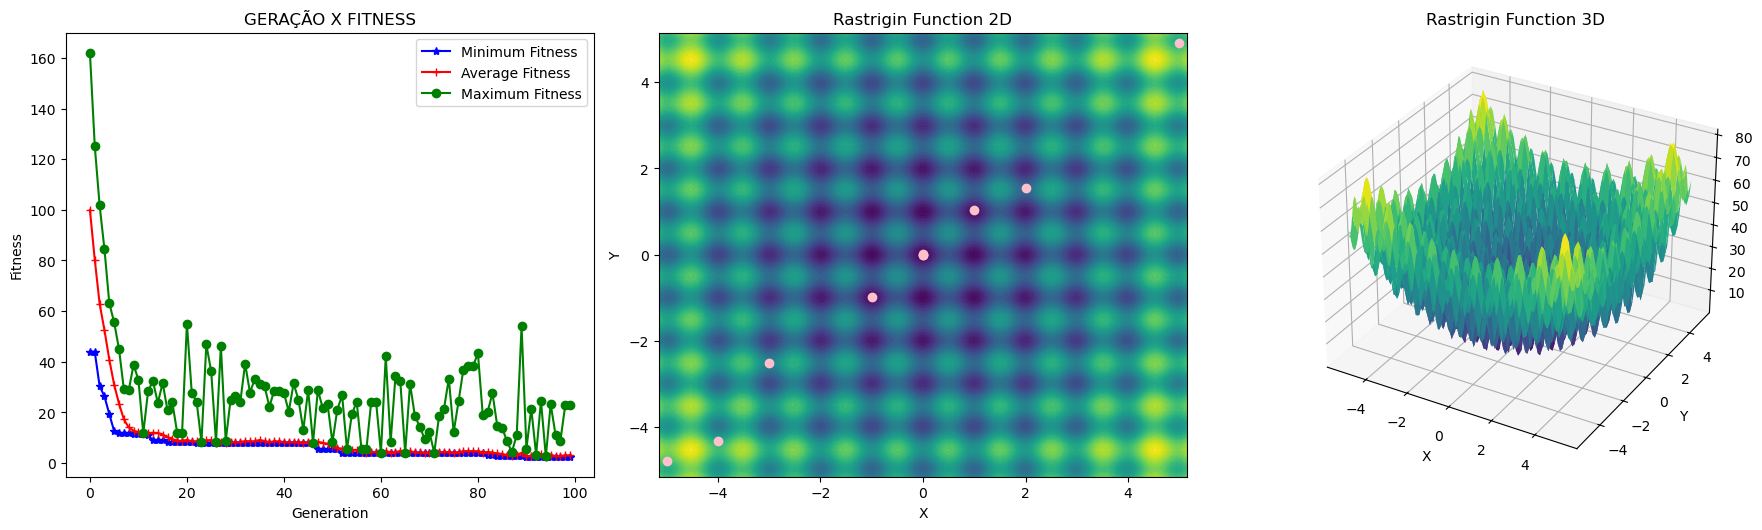

Soluções do problema

Best solution index =  90

Best solution variables =
 [-0.9909404296332205, -0.016195748733135618, 0.013232090420101206, -0.002564335276322636, 1.040894412336176, 4.37873746774707, -4.779058625442909, -3.201620297475307, -4.324218319276127, 1.5558264685495335]

Best solution fitness =  2.497932695645977

Ótimo global da função Rastrigin =  71.6402359449331

Solução ótima global =  [-9.94380871e-01 -4.98365541e-04 -9.48953403e-04 -3.64570724e-03
  9.94683607e-01  3.97934335e+00 -4.97596207e+00 -2.98386239e+00
 -3.97921926e+00  1.99068036e+00]

Porcentagem de proximidade da solução em relação ao ótimo global =  96.51322659299163 %

Distância da solução em relação ao ótimo global = <built-in function abs>


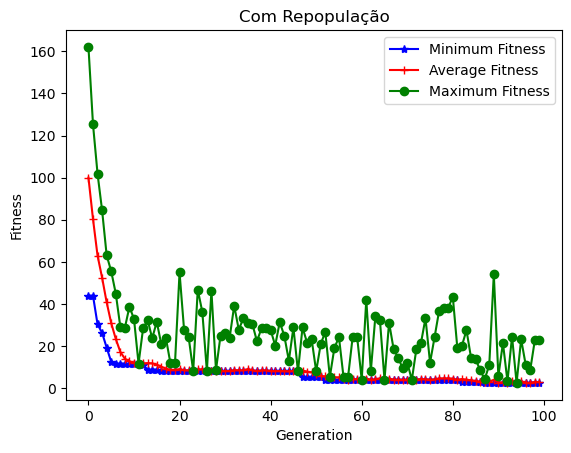

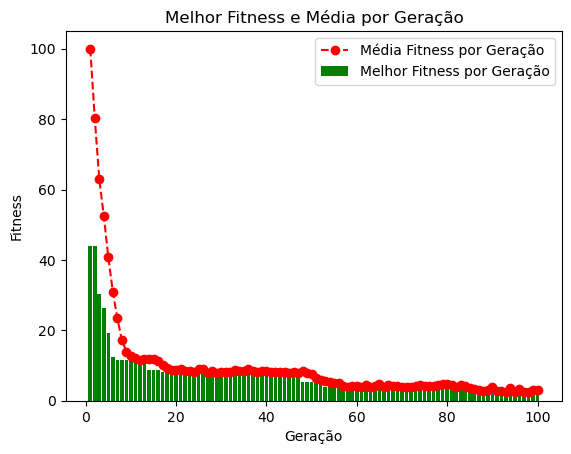

,Generation,Min Fitness,Average Fitness,Max Fitness,Std Fitness
0,0,43.897337,100.003812,162.066235,20.848911
1,1,43.897337,80.292522,125.248993,19.545169
2,2,30.334505,62.932282,101.781295,14.309880
3,3,26.258751,52.438626,84.382810,12.272602
4,4,19.252376,40.770607,63.086750,9.750919
...,...,...,...,...,...
95,95,2.497933,3.235654,23.207648,3.344785
96,96,2.497933,2.584041,11.108802,0.856771
97,97,2.497933,2.617720,8.716859,0.839142
98,98,2.497933,2.958434,22.696025,2.810601


Total execution time: 2.84 seconds


In [15]:
from src.models.AlgEvolution import AlgEvolution

def load_params(file_path):
    with open(file_path, "r") as file:
        params = json.load(file)
    return params

if __name__ == "__main__":
    tempo1 = time.time()





    

    #Setup
    params = load_params("/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/db/parameters.json")
    setup = Setup(params)
    alg = AlgoritimoEvolutivoRCE(setup)
    data_visual = DataExploration()
    #old_alg = AlgEvolution(setup)


    pop_with_repopulation, logbook_with_repopulation, best_variables = alg.run(
        RCE=True,
        fitness_function=rastrigin_decisionVariables,
        decision_variables=(X, y,data_hora,curva,vento),
    )
    
    print("\n\nEvolução concluída  - 100%")


    # Salvar resultados
    print("\n\nRESULTADOS OBTIDOS")
    #data_visual.displayDataFrameInfo(alg.allIndividualValuesArray, "\n\nTodos Individuos Gerados")
    #data_visual.show_conjuntoElite(alg.pop_RCE)
    


    # Visualização dos resultados
    print("\n\nVISUALIZANDO OS RESULTADOS")
    data_visual.show_rastrigin_benchmark(logbook_with_repopulation,best_variables)
    data_visual.visualize(
        logbook_with_repopulation, pop_with_repopulation, repopulation=True
    )
    data_visual.statistics_per_generation_df(logbook_with_repopulation)






    tempo2 = time.time()
    print(f"Total execution time: {round(tempo2-tempo1,2)} seconds")



